In [25]:
import os
import abc
from typing import Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate

%matplotlib inline
pd.set_option("display.precision", 8)
plt.rcParams["figure.figsize"] = (12, 6)

np.random.seed(int.from_bytes(os.urandom(4), byteorder="big"))

In [14]:
class RandomVariable(abc.ABC):
    @abc.abstractmethod
    def generate(self) -> float | int:
        pass

    def generate_series(self, n: int) -> pd.Series:
        return pd.Series([self.generate() for _ in range(n)])


class ExponentialRandomVariable(RandomVariable):
    def __init__(self, lambda_: float):
        self.lambda_: float = lambda_

    def generate(self) -> float:
        u = np.random.uniform(0, 1)
        return -1 / self.lambda_ * np.log(1 - u)

In [15]:
class PoissonProcess(abc.ABC):
    @abc.abstractmethod
    def generate(self, t: float) -> float:
        pass

    def generate_series(self, limit_t: float) -> pd.Series:
        t_ = 0
        s = []
        while True:
            t_ = self.generate(t_)
            if t_ > limit_t:
                break
            s.append(t_)
        s = pd.Series(s)
        return s


class InhomogeneousPoissonProcess(PoissonProcess):
    def __init__(self, lambda_: float, lambda_t: Callable[[float], float]):
        self.lambda_: float = lambda_
        self.lambda_t: Callable[[float], float] = lambda_t

    def generate(self, t: float) -> float:
        while True:
            u1 = np.random.uniform()
            t = t - 1 / self.lambda_ * np.log(u1)
            u2 = np.random.uniform()
            if u2 <= self.lambda_t(t) / self.lambda_:
                return t


class HomogenousPoissonProcess(PoissonProcess):
    def __init__(self, lambda_: float):
        self.lambda_: float = lambda_

    def generate(self, t: float) -> float:
        u = np.random.uniform()
        t = t - 1 / self.lambda_ * np.log(u)
        return t

In [16]:
class QueuingSystem:
    def __init__(self, count: int, poisson_process: PoissonProcess, random_variable: RandomVariable, limit_t: float):
        self.count = count # Количество устройств
        self.limit_t = limit_t # Время конца моделирования
        self.poisson = poisson_process # Пуассоновский процесс, генерирующий события прихода клиента
        self.random = random_variable # Случайная переменная, отвечающая за время обслуживания
        self.na = 0 # Количество поступлений к моменту времени t
        self.t = 0 # Время следующего события
        self.c = [0] * count # Число клиентов, обслуженных устройством к моменту t
        self.i = [0] * count # Обозначение клиента, обслуживаемого устройством
        self.n = 0 # Число клиентов в системе
        self.ti = [np.inf] * count # Время обслуживания текущего клиента в устройстве (если нет клиента, t = inf)
        self.ta = self.poisson.generate(0) # Следующее прибытие клиента
        self.a = [-1] # Время прихода клиента
        self.v = [-1] # Время обслуживания клиента
        self.d = [-1] # Время ухода клиента

    def find_empty_i(self) -> int:
        return next((i for i, x in enumerate(self.i) if x == 0), None)

    def client_comes(self):
        self.t = self.ta # Ставим время следующего поступления
        self.na += 1 # Увеличиваем количество поступлений

        # Генерируем время прибытия следующего клиента
        self.ta = self.poisson.generate(self.ta)
        # Запоминаем приход клиента
        self.a.append(self.t)
        self.d.append(-1)
        self.v.append(-1)

        self.n += 1 # Увеличиваем количество клиентов в системе

        # Находим пустое устройство
        j = self.find_empty_i()
        # Если нет пустых устройств - ждём в очереди
        if j is None:
            return
        # Иначе, занимаем устройство
        self.i[j] = self.na
        # Генерируем время обслуживания
        y = self.random.generate()
        self.v[self.na] = y
        # Запоминаем, сколько клиент будет обслуживаться
        self.ti[j] = self.t + y

    def client_leaves(self, j: int):
        self.t = self.ti[j] # Ставим время завершения обслуживания на устройства
        self.c[j] += 1 # Увеличиваем количество обслуженных клиентов
        # Запоминаем уход клиента
        self.d[self.i[j]] = self.t

        self.n -= 1 # Уменьшаем количество клиентов в системе

        if self.n < self.count:  # Если клиентов в очереди нет, помечаем устройство как пустое
            self.ti[j] = np.inf
            self.i[j] = 0
        else: # Иначе, следующий клиент занимает текущее устройство
            m = max(self.i)
            self.i[j] = m+1
            y = self.random.generate()
            self.v[m+1] = y
            self.ti[j] = self.t + y

    def simulate(self) -> (pd.DataFrame, pd.DataFrame):
        q = []
        while self.ta < self.limit_t or self.n != 0:
            m = min(self.ti)
            if self.ta < m and self.ta < self.limit_t:
                self.client_comes()
            else:
                j = self.ti.index(m)
                self.client_leaves(j)
            q.append((self.t, self.n, len([i for i in self.i if i > 0])))
        df_c = pd.DataFrame.from_dict({
            "a": self.a[1:],
            "d": self.d[1:],
            "v": self.v[1:],
        })
        df_q = pd.DataFrame.from_records(q, columns=["t", "q", "b"])
        return df_c, df_q


In [17]:
POISSON_LAMBDA = 100
def POISSON_LAMBDA_T(t: float) -> float:
    if 0 < t <= 9:
        return 10
    if 9 < t <= 13:
        return 80
    if 13 < t <= 14:
        return 20
    if 14 < t <= 18:
        return 100
    if t > 18:
        return 40
EXP_LAMBDA = 20
COUNT = 4
T = 24

In [18]:
poisson = InhomogeneousPoissonProcess(POISSON_LAMBDA, POISSON_LAMBDA_T)
exp = ExponentialRandomVariable(EXP_LAMBDA)

In [19]:
qs = QueuingSystem(COUNT, poisson, exp, T)
df_c, df_q = qs.simulate()

In [20]:
df_c["w"] = np.round(df_c["d"] - df_c["a"] - df_c["v"], 10)
df_c

,a,d,v,w
0,0.07912825,0.09842528,0.01929703,0.0
1,0.14264261,0.25971011,0.11706751,0.0
2,0.32965629,0.35612037,0.02646407,0.0
3,0.40854302,0.42613281,0.01758978,-0.0
4,0.45670420,0.51384072,0.05713652,0.0
...,...,...,...,...
1072,23.91725728,23.94079557,0.02353829,-0.0
1073,23.91757200,23.92545094,0.00787894,0.0
1074,23.93367163,23.96533472,0.03166309,-0.0
1075,23.93603436,24.08939363,0.15335927,0.0


In [21]:
df_q["delta"] = df_q["q"] - df_q["b"]
df_q

,t,q,b,delta
0,0.07912825,1,1,0
1,0.09842528,0,0,0
2,0.14264261,1,1,0
3,0.25971011,0,0,0
4,0.32965629,1,1,0
...,...,...,...,...
2149,23.94220475,2,2,0
2150,23.96310905,3,3,0
2151,23.96533472,2,2,0
2152,23.97442947,1,1,0


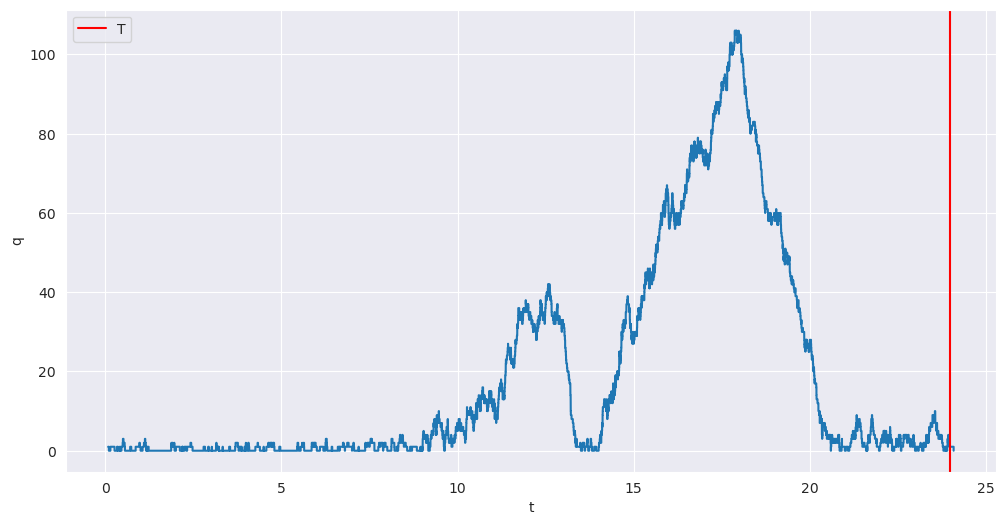

In [26]:
sns.lineplot(df_q[["t", "q"]], x="t", y="q", drawstyle='steps-post')
plt.axvline(T, color="red", label="T")
plt.legend()

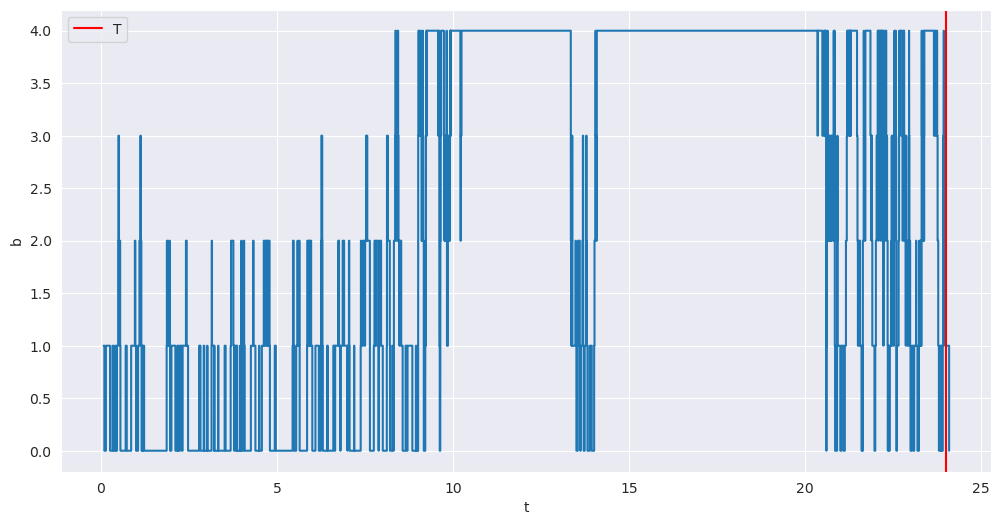

In [27]:
sns.lineplot(df_q[["t", "b"]], x="t", y="b", drawstyle='steps-post')
plt.axvline(T, color="red", label="T")
plt.legend()

In [28]:
t_max = df_q.t.max()
ro = df_q.apply(lambda g: integrate.trapz(df_q.b, x=df_q.t))["b"] / t_max
qo = df_q.apply(lambda g: integrate.trapz(df_q.delta, x=df_q.t))["delta"] / t_max


df = pd.DataFrame.from_dict({
    "Среднее время между поступлениями": df_c["a"].diff().mean(),
    "Среднее время обслуживания": df_c["v"].mean(),
    "Число клиентов n": len(df_c.index),
    "Средняя задержка в очереди": df_c["w"].mean(),
    "Среднее число клиентов в очереди": qo,
    "Коэффициент занятости устройств обслуживания": ro,
    "Длительность моделируемого периода": max(df_q.t),
    "Среднее время, проведённое клиентами в системе": (df_c["d"] - df_c["a"]).mean()
}, orient="index")
df

,0
Среднее время между поступлениями,0.02219701
Среднее время обслуживания,0.05222827
Число клиентов n,1077.00000000
Средняя задержка в очереди,0.35837546
Среднее число клиентов в очереди,16.00941381
Коэффициент занятости устройств обслуживания,2.41864178
Длительность моделируемого периода,24.08939363
"Среднее время, проведённое клиентами в системе",0.41060373
